# NLI with XLM-RoBERTa 
This Kaggle kernel is a submission for the "Contradictory, My Dear Watson" competition. The goal is to create an NLI (Natural Language Inferencing) model that, given a premise and a corresponding hypothesis, can determine whether the relationship between the two is an entailment, is neutral, or is a contradiction. We tackle this task by implementing a Hugging Face transformer, **XLM-RoBERTa**, with some other data handling techniques.

이 Kaggle kernel은 "Contradictory, My Dear Watson" 대회를 위해 제작되었습니다. 이 대회의 목적은 전제와 가설 문장 각 하나씩을 두고 둘의 관계가 수반되는지, 중립적인지, 아니면 상반되는지를 분류하는 NLI (Natural Language Inferencing) 모델을 만드는 것입니다. 이를 위해 Hugging Face의 transformer 중 하나인 **XLM-RoBERTa**와 다른 데이터처리 기법들을 활용합니다.

# Kernel Setup
## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
!pip install nlpaug
import nlpaug.augmenter.word as naw
from tqdm import tqdm
from transformers import XLMRobertaTokenizer, TFXLMRobertaModel
import matplotlib.pyplot as plt
import plotly.express as px

     |████████████████████████████████| 394 kB 2.9 MB/s 


## Setup TPU
We utilize the TPU to accelerate model training.

더 빠른 모델 훈련을 위해 TPU를 사용합니다.

In [2]:
try: # running on TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError: # running on GPU/CPU
    print('Not running on TPU')
    strategy = tf.distribute.get_strategy()
print("REPLICAS:", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS: 8


## Load Data
We load and check the given data.

입력 데이터를 읽어들이고 확인해봅니다.

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train_df = pd.read_csv('../input/contradictory-my-dear-watson/train.csv')
test_df = pd.read_csv('../input/contradictory-my-dear-watson/test.csv')
submission_df = pd.read_csv('../input/contradictory-my-dear-watson/sample_submission.csv')
train_df.head()

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [4]:
test_df.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [5]:
submission_df.head()

,id,prediction
0,c6d58c3f69,1
1,cefcc82292,1
2,e98005252c,1
3,58518c10ba,1
4,c32b0d16df,1


Observation(s):
* The *id* column seems unnecessary as it does not include useful information.
* The *lang_abv* and *language* columns seem unnecessary as the **XLM-RoBERTa** transformer is a multilingual model which ["does not require *lang* tensors to understand which language is used."](https://huggingface.co/transformers/model_doc/xlmroberta.html)

Decision(s):
* Drop the *id*, *lang_abv*, and *language* columns from the dataset.

관찰:
* *id* 열은 별 다른 정보를 주지 않으므로 필요가 없어 보입니다.
* **XLM-RoBERTa** transformer는 다중언어 모델로서 [입력 데이터의 언어에 대한 안내가 필요 없으므로](https://huggingface.co/transformers/model_doc/xlmroberta.html) *lang_abv* 와 *lanugage* 열은 필요가 없어 보입니다.

결정:
* *id*, *lang_abv*, *language* 열들을 데이터셋에서 제외시킵니다.

# Preprocess Data
## Train/Validation Split
We keep only the necessary columns (*premise*, *hypothesis*, *label*) and perform a train/validation split to evaluate our model during training.

필요한 열들만 (*premise*, *hypothesis*, *label*) 유지하고 모델 훈련 중 평가를 위해 훈련 데이터셋을 훈련/검증 데이터셋들로 나눕니다.

In [6]:
train_text_df, val_text_df, train_label, val_label = train_test_split(
    train_df[['premise', 'hypothesis']], train_df['label'].values.tolist(),
    test_size=0.2)

test_text_df = test_df[['premise', 'hypothesis']]

## Data Augmentation
### Synonym Augmenter
We perform data augmentation in order to increase the size of our training set and prevent overfitting. As we are dealing with text data, we use a **synonym augmenter** from the ["nlpaug"](https://pypi.org/project/nlpaug/0.0.9/) library. Below is an example.

훈련 데이터셋을 더 늘려서 과적합을 예방하기 위해 데이터 증강을 적용합니다. 텍스트 데이터이므로 ["nlpaug"](https://pypi.org/project/nlpaug/0.0.9/) 라이브러리의 **synonym augmenter**를 사용합니다. 아래에 예시가 있습니다.

In [7]:
syn_aug = naw.SynonymAug()

original_sample = train_df['premise'].iloc[1]
print('Original:  {}'.format(original_sample))

augmented_sample = syn_aug.augment(original_sample)
print('Augmented: {}'.format(augmented_sample))

Original:  These are issues that we wrestle with in practice groups of law firms, she said. 
Augmented: These are progeny that we wrestle with in practice chemical group of law business firm, she said.


A synonym augmenter substitutes text data with a corresponding synonym listed in the WordNet database. For our model training, we decide to add about 25% of augmented data to the training set. We **do not apply this data augmentation to the validation dataset** because we should evaluate our model on data closest to real data.

동의어 augmenter는 WordNet 데이터베이스에 기록된 텍스트 데이터 단어의 동의어로 대체해줍니다. 우리의 모델 훈련을 위해 훈련 데이터셋의 25%를 증강 데이터로 추가하기로 합니다. 주의할 것은 모델 검증을 실제 데이터에 가장 가까운 데이터로 해야하므로 이 **데이터 증강을 검증 데이터셋에 적용하지 않습니다**. 

In [8]:
new_prem_text = []
new_hypo_text = []
new_label = []

for i in tqdm(np.random.randint(0, len(train_text_df), len(train_text_df) // 4)): # divide by 4 to get 25%
    prem_text = train_text_df.iloc[i]['premise']
    hypo_text = train_text_df.iloc[i]['hypothesis']
    
    # augment both the premise and the hypothesis
    aug_prem_text = syn_aug.augment(prem_text) 
    aug_hypo_text = syn_aug.augment(hypo_text)

    new_prem_text.append(aug_prem_text)
    new_hypo_text.append(aug_hypo_text)
    
    # match label to new texts
    text_label = train_label[i]
    new_label.append(text_label)

aug_train_text_df = train_text_df.append(pd.DataFrame({'premise': new_prem_text, 'hypothesis': new_hypo_text}))
aug_train_label = train_label + new_label

print('Amount before augmentation: {} texts, {} labels.'.format(train_text_df.shape[0], len(train_label)))
print('Amount after augmentation:  {} texts, {} labels.'.format(aug_train_text_df.shape[0], len(aug_train_label)))

100%|██████████| 2424/2424 [08:16<00:00,  4.89it/s]

Amount before augmentation: 9696 texts, 9696 labels.
Amount after augmentation:  12120 texts, 12120 labels.


## Setup Tokenizer
A transformer takes token input ids as input, so we need a tokenizer to first encode the text data into tokens.

Transformer는 token input id를 입력값으로 받기 때문에 우선 텍스트 데이터를 token으로 부호화해줄 tokenizer가 필요합니다.

In [9]:
PRETRAINED_MODEL = 'jplu/tf-xlm-roberta-large'

tokenizer = XLMRobertaTokenizer.from_pretrained(PRETRAINED_MODEL)

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

## Determine *MAX_LEN* for Encoding
We need to set a max length for the text inputs in order to keep the token lengths equal. Shorter texts will be padded up to the max length, while longer texts will be truncated to it. Too much padding will lead to tokens not carrying information, whereas too much truncation will lead to losing useful information. We determine the appropriate size by examining the length distribution of the encoded tokens.

Token들의 길이를 일정하게 하기 위해 텍스트 입력값들의 최대 길이를 설정해줘야합니다. 최대 길이보다 짧은 텍스트들은 최대 길이만큼 padding 되어서 길어지고, 더 긴 텍스트들은 최대 길이만큼 truncate 되어서 짧아집니다. 과한 padding은 정보가 담기지 않은 token들을 생성하고, 과한 truncation은 유용한 정보를 잃게 합니다. 적당한 길이를 정하기 위해 부호화된 token들의 길이 분포를 확인해봅니다. 

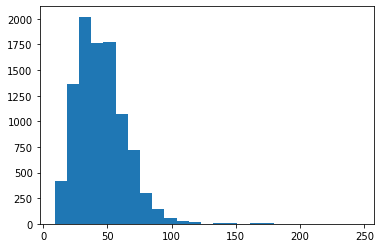

In [10]:
train_encoded_temp = tokenizer(
    train_text_df.values.tolist(),
    return_length=True)

plt.hist(train_encoded_temp.length, bins=25)
plt.show()

In [11]:
temp_df = pd.DataFrame(train_encoded_temp.length, columns=['length'])
temp_df.describe(percentiles=[.75,.9,.95,.99])

,length
count,9696.000000
mean,44.953280
std,19.150978
min,9.000000
50%,43.000000
75%,56.000000
90%,69.000000
95%,78.000000
99%,98.000000
max,246.000000


Observation(s):
* The length distribution is heavily skewed to the left.
* While the longest is 246 tokens long, the 99th percentile text's length is 98 tokens long.

Decision(s):
* A max length of around 80 tokens seems appropriate, retaining about 95% of the data.

관찰:
* 길이 분포가 왼쪽으로 크게 왜곡되어습니다.
* 가장 긴 값은 246 토큰만큼 길지만, 99번째 백위분수 텍스트의 길이는 98 토큰만큼 깁니다.

결정:
* 80 토큰의 최대 길이가 95% 정도의 데이터를 포함하므로 적당해보입니다. 

In [12]:
MAX_LENGTH = 80

## Encode Text Input and Obtain Input Ids
The transformer takes tokens by their input ids, so we need to obtain the input ids of the training, validation, and test datasets.

Transformer는 token들의 input id들을 읽어들이기 때문에 훈련, 검증, 시험 데이터셋의 input id들을 구해야합니다.

In [13]:
train_encoded = tokenizer(
    aug_train_text_df.values.tolist(), 
    max_length=MAX_LENGTH, 
    padding='max_length', 
    truncation='longest_first')
val_encoded = tokenizer(
    val_text_df.values.tolist(), 
    max_length=MAX_LENGTH, 
    padding='max_length', 
    truncation='longest_first')
test_encoded = tokenizer(
    test_text_df.values.tolist(),
    max_length=MAX_LENGTH, 
    padding='max_length', 
    truncation='longest_first')

train_ids = train_encoded['input_ids']
val_ids = val_encoded['input_ids']
test_ids = test_encoded['input_ids']

## Convert to TensorFlow Dataset
We convert the data into TensorFlow datasets which the model can read in during training, and to enable training on TPUs.

TPU에 모델 훈련을 시킬 수 있기 위해 데이터를 TensorFlow dataset 형태로 전환해줍니다.

In [14]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync # for each TPU unit
AUTO = tf.data.experimental.AUTOTUNE

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_ids, aug_train_label))
    .shuffle(len(train_ids), reshuffle_each_iteration=True) # for perfect shuffle
    .batch(BATCH_SIZE)
    .prefetch(AUTO))
val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_ids, val_label))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO))
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_ids)
    .batch(BATCH_SIZE))

# Model Training
## Creating and Loading Model onto TPU
We setup the model within a *strategy.scope()* in order to use the TPU. We add dropout and batch normalization layers in order to prevent overfitting, and decrease the Adam optimizer's learning rate to 1e-5 as the default learning rate of 1e-3 seems to cause the model to diverge.

모델 훈련을 TPU로 하기 위해 *strategy.scope()* 안에서 구축합니다. 과적합을 예방하기 위해 dropout과 batch normalization layer들을 추가하고, Adam optimizer의 기본 학습률 1e-3은 모델이 diverge하게 만드는 것으로 보이기에 학습률을 1e-5로 낮춰줍니다.

In [15]:
with strategy.scope():
    # setup XLM-RoBERTa model
    transformer_encoder = TFXLMRobertaModel.from_pretrained(PRETRAINED_MODEL)

    # take in inputs and generate necessary outputs
    input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_ids')
    sequence_output = transformer_encoder(input_ids)[0]
    cls_token = sequence_output[:, 0, :]
    
    # prevent overfitting
    dropout = tf.keras.layers.Dropout(0.3)(cls_token) # prevent overfitting
    batch_norm = tf.keras.layers.BatchNormalization()(dropout) # prevent overfitting
    
    output = tf.keras.layers.Dense(3, activation='softmax')(batch_norm)

    model = tf.keras.Model(inputs=input_ids, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-6), # default lr doesn't converge
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy'])

model.summary()

Downloading:   0%|          | 0.00/513 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.27G [00:00<?, ?B/s]

Some layers from the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 80)]              0         
_________________________________________________________________
tfxlm_roberta_model (TFXLMRo TFBaseModelOutputWithPool 559890432 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 1024)              0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 559,897,603
Trainable params: 559,895,555
Non-trainable params: 2,048
___________________________________________

## Early Stopping
Set up an early stopping callback to train the model up to when the lowest validation loss is obtained.

모델을 최저 검증 손실값을 얻었을 때까지 훈련 시키기 위해 early stopping callback을 만들어줍니다.

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience= 10, # stops training after 10 consecutive non-decreases in min val loss
    verbose=1,
    mode='auto',
    restore_best_weights=True)

## Train Model
We now train the model to learn the premise and hypothesis relationships.

이제 모델이 전제와 가설들의 관계를 학습하기 위해 훈련시킵니다.

In [17]:
EPOCHS = 100

train_history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_dataset)

Epoch 1/100


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


95/95 [==============================] - 273s 1s/step - loss: 1.4271 - accuracy: 0.3237 - val_loss: 1.0979 - val_accuracy: 0.3445
Epoch 2/100
95/95 [==============================] - 23s 245ms/step - loss: 1.3338 - accuracy: 0.3486 - val_loss: 1.0973 - val_accuracy: 0.3540
Epoch 3/100
95/95 [==============================] - 23s 247ms/step - loss: 1.3139 - accuracy: 0.3368 - val_loss: 1.0964 - val_accuracy: 0.3601
Epoch 4/100
95/95 [==============================] - 23s 245ms/step - loss: 1.2931 - accuracy: 0.3405 - val_loss: 1.0983 - val_accuracy: 0.3494
Epoch 5/100
95/95 [==============================] - 23s 245ms/step - loss: 1.2894 - accuracy: 0.3382 - val_loss: 1.0988 - val_accuracy: 0.3573
Epoch 6/100
95/95 [==============================] - 23s 246ms/step - loss: 1.2669 - accuracy: 0.3518 - val_loss: 1.0964 - val_accuracy: 0.3535
Epoch 7/100
95/95 [==============================] - 23s 247ms/step - loss: 1.2590 - accuracy: 0.3396 - val_loss: 1.0940 - val_accuracy: 0.3717
Epoch 

# Model Performance
We examine the model training's validation loss and accuracy to see how well it learned.

모델이 얼마나 잘 학습되었는지 알아보기 위해 검증 손실값과 정확도를 살펴봅니다.

In [18]:
history = train_history.history

px.line(
    history, 
    x=range(1, len(history['loss'])+1), 
    y=['loss', 'val_loss'], 
    title='Model Loss', 
    labels={'x': 'Epoch', 'value': 'Loss'}
)

In [19]:
px.line(
    history, 
    x=range(1, len(history['loss'])+1), 
    y=['accuracy', 'val_accuracy'], 
    title='Model Accuracy', 
    labels={'x': 'Epoch', 'value': 'Accuracy'}
)

# Test Predictions
We make predictions on the test dataset to submit to the competition.

대회에 제출하기 위해 시험 데이터셋을 모델에 입력해서 예측값들을 얻어냅니다.

In [20]:
test_preds = model.predict(test_dataset, verbose=1)
submission_df['prediction'] = test_preds.argmax(axis=1)
submission_df.head()
submission_df.to_csv('submission.csv', index=False)

41/41 [==============================] - 34s 610ms/step
